# Sample Size Selection

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1clg1md/determining_sample_size_q).

> Hi Redditors, I am a civil engineer trying to solve a statistical problem for a current project I have. I have a pavement parking lot 125,000 sf in size. I performed nondestructive testing to render an opinion about the areas experiencing internal delimitation not observable from the surface. Based on preliminary testing, it was determined that 9% of the area is bad, and 11% of the total area 1 am unsure about (nonconclusive results if bad or good), and 80% of the area is good. I need to verify all areas using destructive testing, I will take out slabs 2 sf in size. my question is how many samples do I need to take from each area to confirm the results with 95% confidence interval? I have a basic background in statistics. I thought it was an iterative problem because I would not know the standard deviation for the sample to render an opinion about the population average with a 95% confidence interval until I test the samples extracted. However, the chatgpt approached the problem differently, not even using the sample size area in the analysis, it did a different analysis based on the proportion size, and 1 got so confused. any help would be truly appreciated. Thanks 

We have some modeling to do before we can answer this question.
If the parking lot is 125,000 sf and each sample is 2 sf, we can imagine dividing the total area into 62,500 test patches.
Of those, some unknown proportion are good and the rest are bad.

In reality, there is probably some spatial correlation -- if a patch is bad, the nearby patches are more likely to be bad.
But if we choose a sample of patches entirely at random, we can assume that they are independent.

In that case, the goal is to estimate the proportion of patches that are bad, and to quantify the precision of that estimate by computing a confidence interval.

The question is about sample size selection, but it doesn't say what the requirements are.
For example, if the 95% confidence interval needs to be smaller than a given threshold, we could choose a sample size to meet that requirement.
Since we don't have that information, we'll try a few sample sizes and see what we get.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/heterosked.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## The beta-binomial model

Based on preliminary testing, it is likely that the proportion of good patches is between 80% and 90%.
We can take advantage of that information by using a beta distribution as a prior and updating it with the data.

Here's a prior distribution that seems like a reasonable choice.

In [3]:
from scipy.stats import beta as beta_dist

prior = beta_dist(8, 2)
prior.mean()

0.8

The prior mean is at the low end of the likely range, so the results will be a little conservative.
Here's what the prior looks like.

In [4]:
def plot_dist(dist, **options):
    qs = np.linspace(0, 1, 101)
    ps = dist.pdf(qs)
    ps /= ps.sum()
    plt.plot(qs, ps, **options)

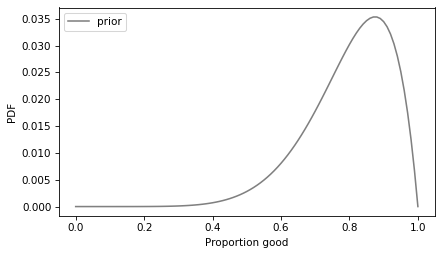

In [5]:
plot_dist(prior, color='gray', label='prior')

decorate(xlabel='Proportion good',
         ylabel='PDF')

The prior leaves open the possibility of values below 80% and greater than 90%, but it assigns them lower probabilities.

Now let's generate a hypothetical dataset to see what the update looks like.
Suppose the actual percentage of good patches is 90%, and we sample `n=10` of them.

In [6]:
def generate_data(n, p):
    yes = int(round(n * p))
    no = n - yes
    return yes, no

And suppose that, in line with expectations, 9 out of 10 tests are good.

In [7]:
yes, no = generate_data(n=10, p=0.9)
yes, no

(9, 1)

Under the beta-binomial model, computing the posterior is really easy.

In [8]:
def update(dist, yes, no):
    a, b = dist.args
    return beta_dist(a + yes, b + no)

The posterior mean is 85%, which is half way between the prior mean and the proportion observed in the data.

In [9]:
posterior10 = update(prior, yes, no)
posterior10.mean()

0.85

And here's what the posterior distribution looks like.

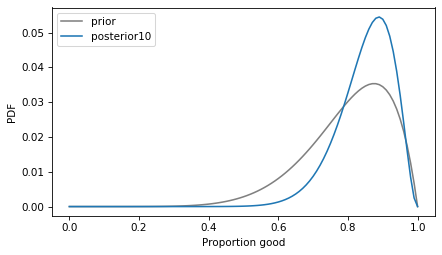

In [10]:
plot_dist(prior, color='gray', label='prior')
plot_dist(posterior10, label='posterior10')

decorate(xlabel='Proportion good',
         ylabel='PDF')

For optimization, it is ideal to take advantage of the entire posterior distribution, but if a confidence interval is required, we can compute it like this.

In [11]:
def confidence_interval(dist, percent=95):
    low = (100 - percent) / 200
    high = 1 - low
    ci = dist.ppf([low, high])
    return ci

In [12]:
confidence_interval(posterior10)

array([0.66862334, 0.96617375])

With a sample size of only 10, the confidence interval is still quite wide -- that is, the estimate of the proportion is not precise.

## More data?

Now let's run the same analysis with a sample size of `n=100`.

In [13]:
yes, no = generate_data(n=100, p=0.9)
posterior100 = update(prior, yes, no)
posterior100.mean()

0.8909090909090909

With a larger sample size, the posterior mean is closer to the proportion observed in the data.
And the posterior distribution is narrower, which indicates greater precision.

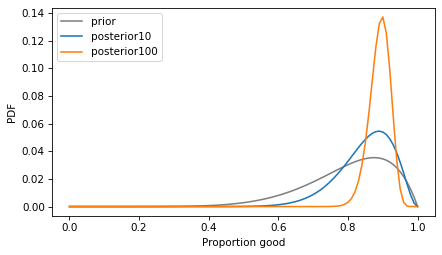

In [14]:
plot_dist(prior, color='gray', label='prior')
plot_dist(posterior10, label='posterior10')
plot_dist(posterior100, label='posterior100')

decorate(xlabel='Proportion good',
         ylabel='PDF')

The confidence interval is much smaller.

In [15]:
confidence_interval(posterior100)

array([0.82660267, 0.94180387])

If we need more precision than that, we could increase the sample size more.
If we don't need that much precision, we could decrease it.

With some math, we could compute the sample size algorithmically, but for practical purpose, we could run this notebook a few times until we get the results we need.

## But what about that prior?

Some people don't like using Bayesian methods because they think it is more objective to ignore perfectly good background information, even in cases like this where they come from preliminary testing that is clearly applicable.

To satisfy them, we can run the analysis again with a uniform prior, which is not actually more objective, but it seems to make people happy.

In [16]:
uniform_prior = beta_dist(1, 1)
uniform_prior.mean()

0.5

The mean of the uniform prior is 50%, so it is more pessimistic.
Here's the update with `n=10`.

In [17]:
yes, no = generate_data(n=10, p=0.9)
uniform_posterior10 = update(uniform_prior, yes, no)
uniform_posterior10.mean()

0.8333333333333334

Now let's compare the posterior distributions with the informative prior and the uniform prior.

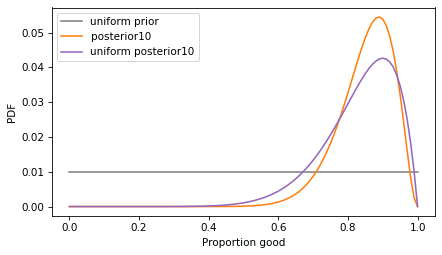

In [18]:
plot_dist(uniform_prior, color='gray', label='uniform prior')
plot_dist(posterior10, color='C1', label='posterior10')
plot_dist(uniform_posterior10, color='C4', label='uniform posterior10')

decorate(xlabel='Proportion good',
         ylabel='PDF')

With the informative prior, the posterior distribution is a little narrower -- an estimate that uses background information is more precise.

Let's do the same thing with `n=100`.

In [19]:
uniform_prior = beta_dist(1, 1)
yes, no = generate_data(n=100, p=0.9)
uniform_posterior100 = update(uniform_prior, yes, no)

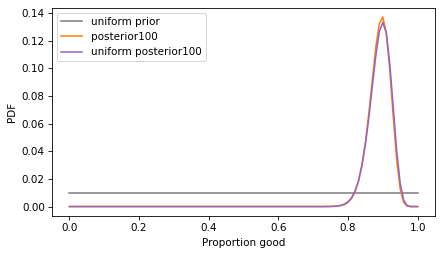

In [20]:
plot_dist(uniform_prior, color='gray', label='uniform prior')
plot_dist(posterior100, color='C1', label='posterior100')
plot_dist(uniform_posterior100, color='C4', label='uniform posterior100')

decorate(xlabel='Proportion good',
         ylabel='PDF')

With a larger sample size, the choice of the prior has less effect -- the posterior distributions are almost the same.

## Discussion

Sample size analysis is a good thing to do when you are designing experiments, because it requires you to

* Make a model of the data-generating process,

* Generate hypothetical data, and

* Specify ahead of time what analysis you plan to do.

It also gives you a preview of what the result might look like, so you can think about the requirements.
If you do these things before running an experiment, you are likely to clarify your thinking, communicate better, and improve the data collection process and analysis.

Sample size analysis can also help you choose a sample size, but most of the time that's determined by practical considerations, anyway.
I mean, how many holes do you think they'll let you put in that parking lot?

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)